            Price  Load Forecast  Actual Load  Wind Offshore  [MW]
count  503.000000     503.000000   503.000000           503.000000
mean    61.126243    3472.730451  3346.395208          1487.178804
std     20.674447     333.127705   295.336553           975.818246
min     -0.100000    2674.916667  2686.187500            81.958333
25%     47.020000    3253.026268  3151.562500           656.270833
50%     55.970000    3443.583333  3321.666667          1315.875000
75%     72.505000    3722.125000  3595.395833          2172.375000
max    155.570000    4189.500000  3973.250000          4357.458333

Missing Values:
Price                  0
Load Forecast          0
Actual Load            0
Wind Offshore  [MW]    0
dtype: int64


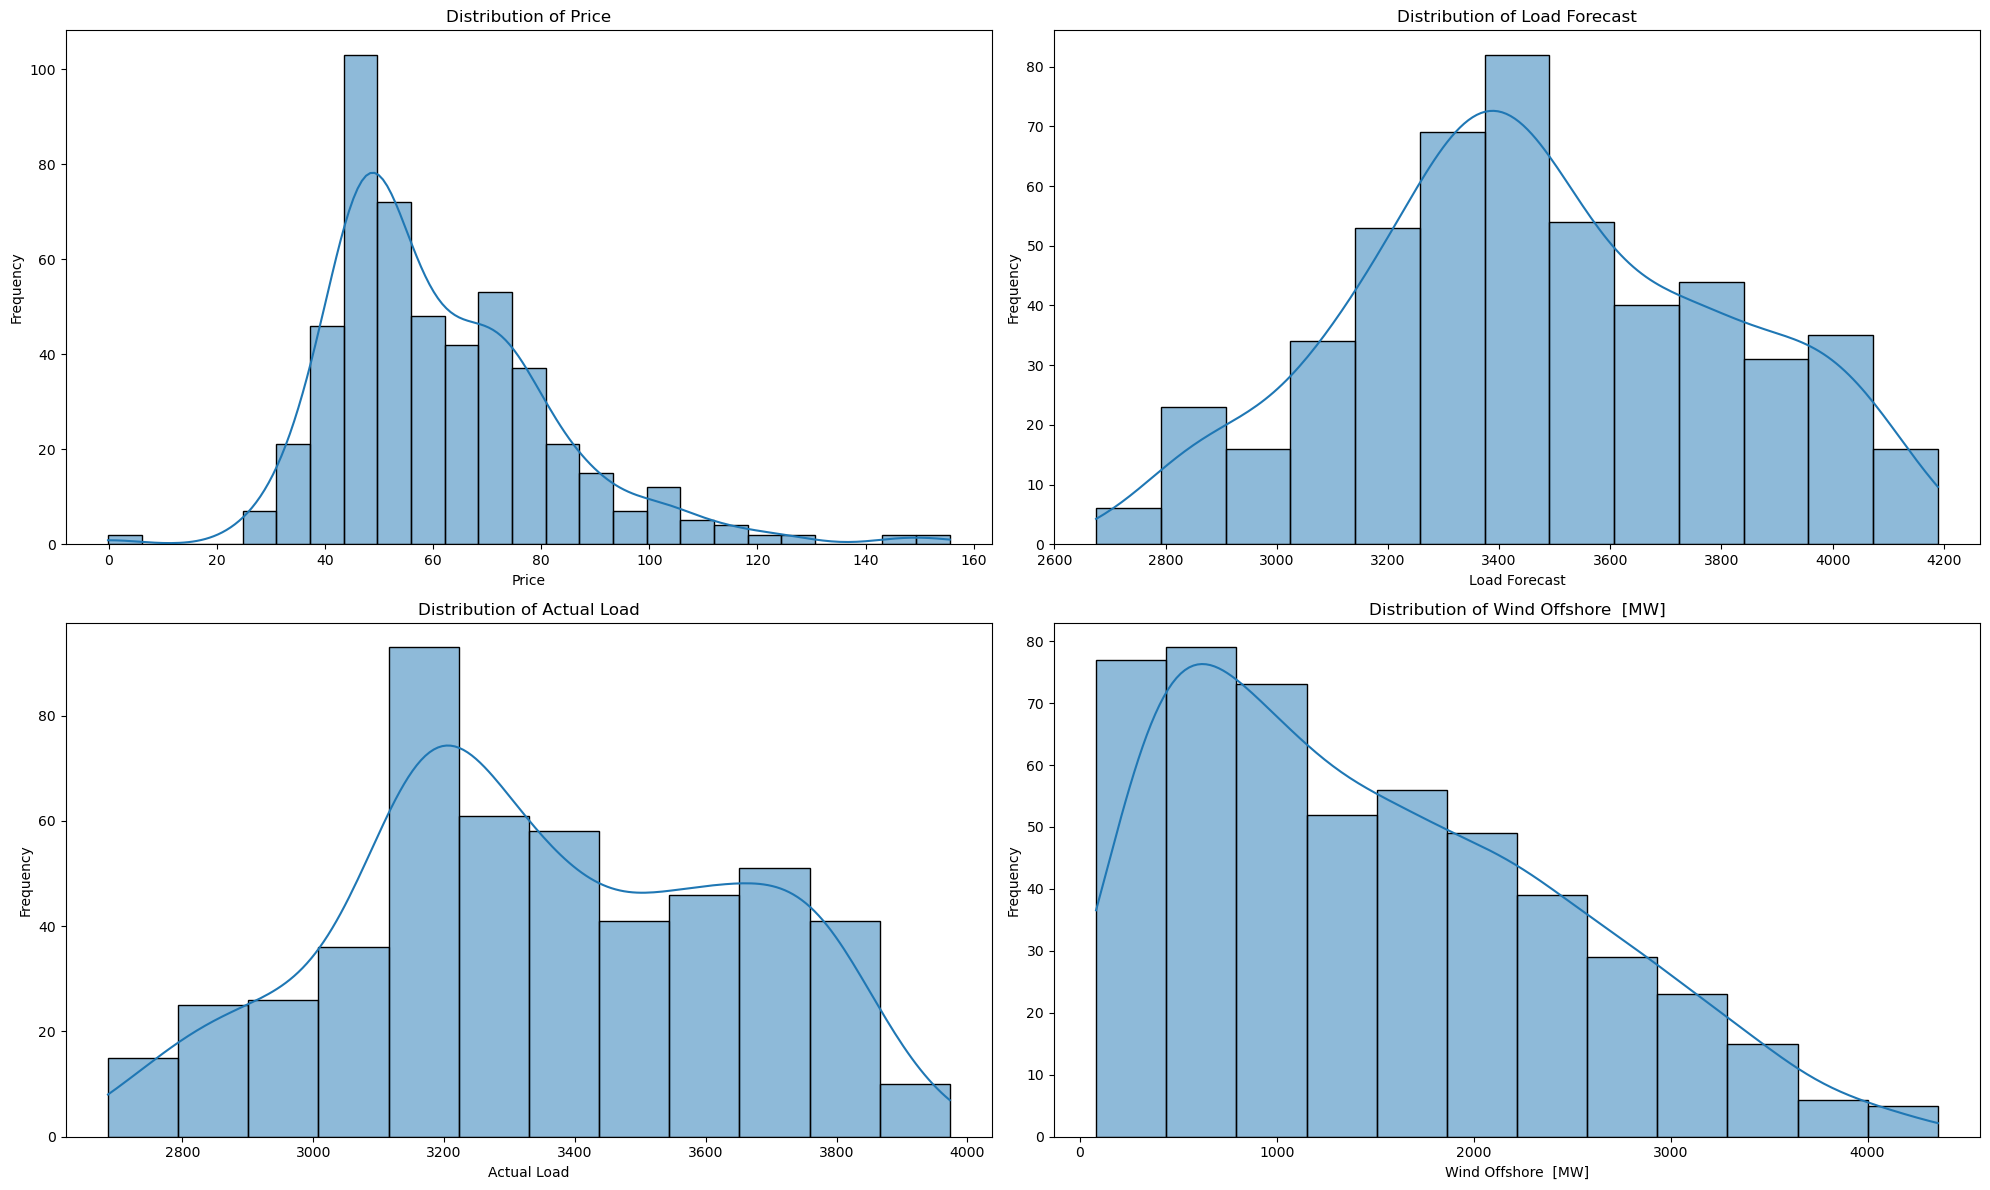

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('merged_dataset-2018-2020.csv')

# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# 1. Summary Statistics
print(df.describe())

# 2. Missing Values Check
print("\nMissing Values:")
print(df.isnull().sum())

# 3. Distribution of Each Feature
plt.figure(figsize=(20, 12))

for i, col in enumerate(df.columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()

plt.show()



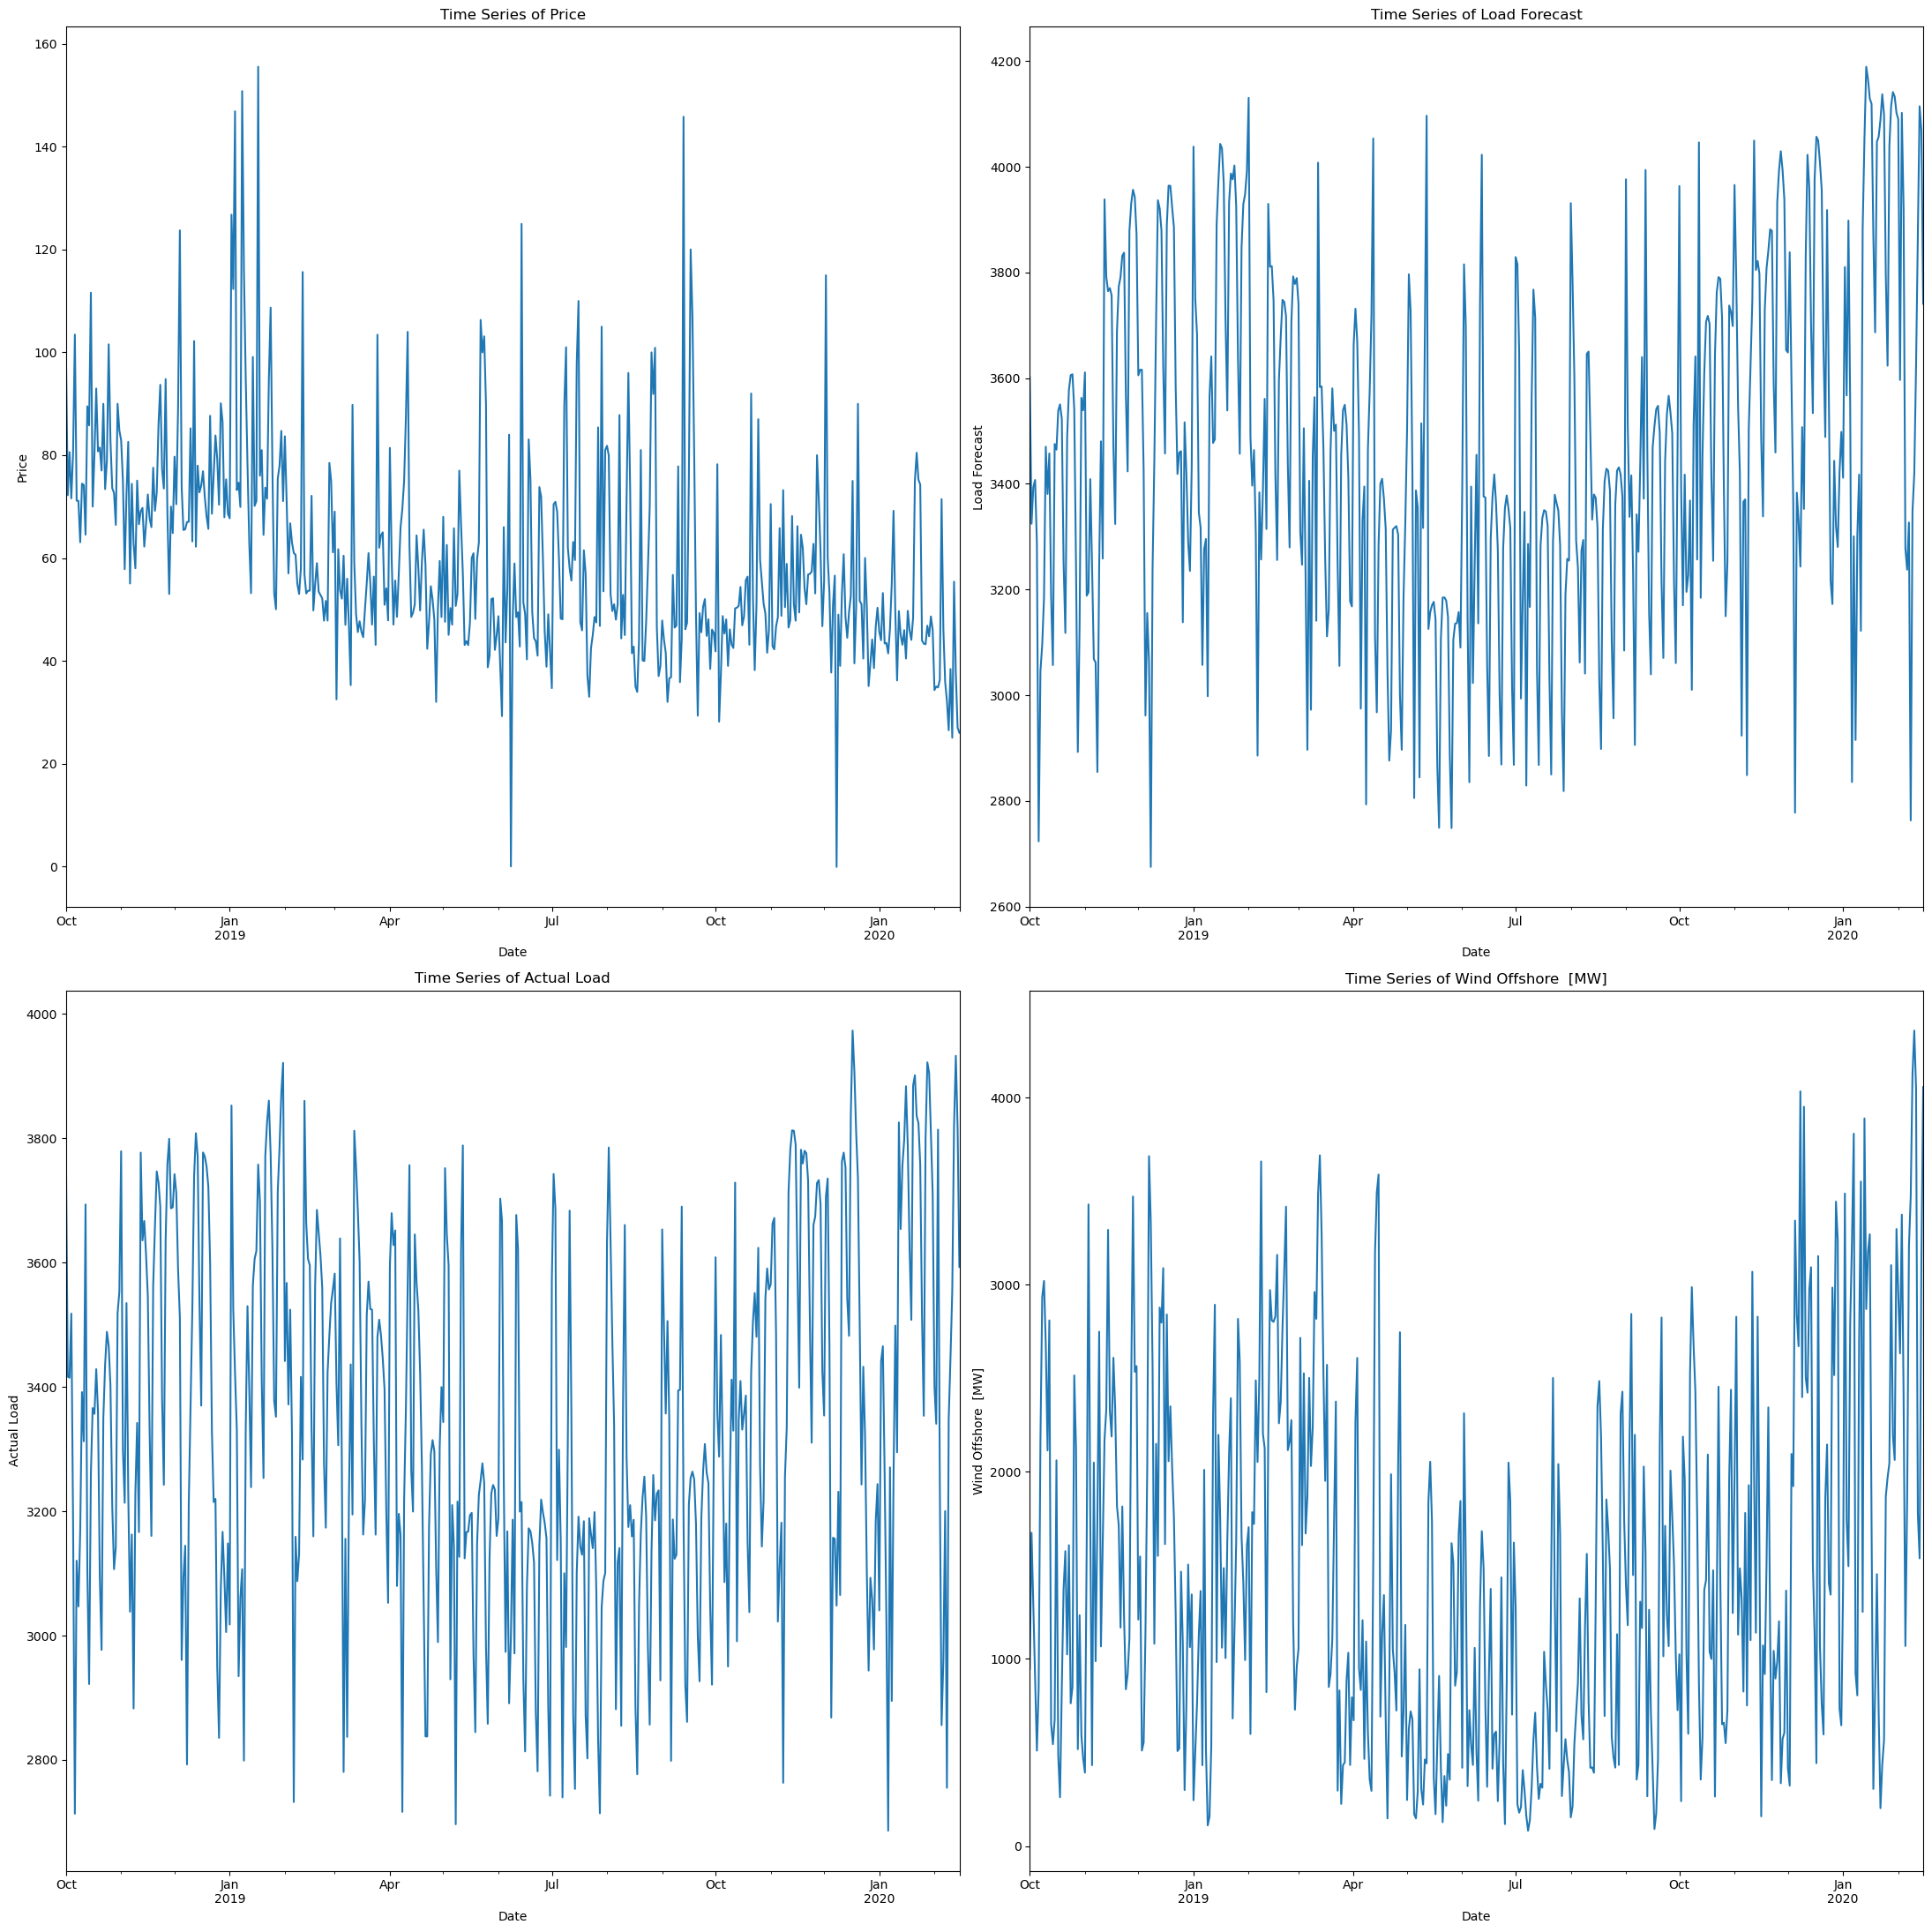

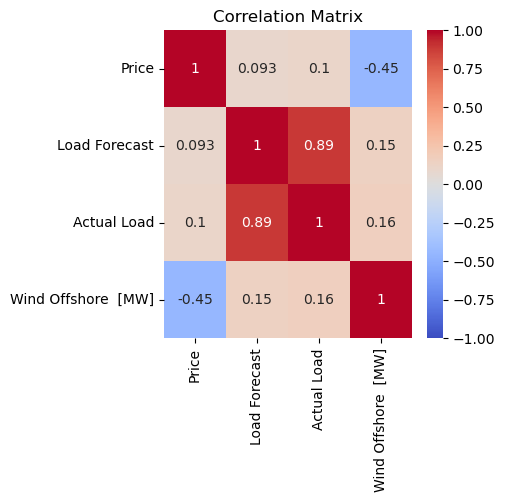

In [2]:
# 4. Time Series Plot of Each Feature
plt.figure(figsize=(22, 22))

for i, col in enumerate(df.columns, 1):
    plt.subplot(2, 2, i)
    df[col].plot()
    plt.title(f'Time Series of {col}')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.tight_layout()

plt.show()

# 5. Correlation Analysis
corr_matrix = df.corr()
plt.figure(figsize=(4, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.regularizers import L1L2

# Load the dataset
df = pd.read_csv('merged_dataset-2018-2020.csv')

# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
dates = df['Date'].tolist()

# Generate lag features for all the variables except the target
num_lags = 7
for col in df.columns:
    if col != 'Price':
        for lag in range(1, num_lags + 1):
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)

# Drop any columns with datetime data type
df = df.select_dtypes(exclude=['datetime64'])

# Drop NaN rows introduced by the lag features
df.dropna(inplace=True)

# Splitting the dataset
n_train_hours = int(len(df) * 0.8)
train, test = df.iloc[:n_train_hours, :], df.iloc[n_train_hours:, :]

# Extract test dates
test_dates = dates[n_train_hours:n_train_hours + len(test)]

# Separating the target variable
train_X, train_y = train.drop(columns=['Price']), train['Price']
test_X, test_y = test.drop(columns=['Price']), test['Price']

# Scaling the dataset
scaler_X = StandardScaler().fit(train_X)
train_X_scaled = scaler_X.transform(train_X)
test_X_scaled = scaler_X.transform(test_X)

scaler_y = StandardScaler().fit(train_y.values.reshape(-1, 1))
train_y_scaled = scaler_y.transform(train_y.values.reshape(-1, 1))
test_y_scaled = scaler_y.transform(test_y.values.reshape(-1, 1))

# Reshaping for LSTM
train_X_reshaped = train_X_scaled.reshape((train_X_scaled.shape[0], 1, train_X_scaled.shape[1]))
test_X_reshaped = test_X_scaled.reshape((test_X_scaled.shape[0], 1, test_X_scaled.shape[1]))


# LSTM Model Architecture
model = Sequential()

# Input Layer
model.add(LSTM(128, input_shape=(train_X_reshaped.shape[1], train_X_reshaped.shape[2]), return_sequences=True))
model.add(Dropout(0.3))

# Hidden Layers
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(1))

optimizer = Adam(learning_rate=0.01)
model.compile(loss='mae', optimizer=optimizer)

batch_size = 64
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# Training the model
history = model.fit(train_X_reshaped, train_y_scaled, epochs=150, batch_size=batch_size, 
                    validation_data=(test_X_reshaped, test_y_scaled), verbose=2, 
                    shuffle=False, callbacks=[early_stop])



# Prediction
yhat_scaled = model.predict(test_X_reshaped)

# Inverse scaling for forecast
inv_yhat = scaler_y.inverse_transform(yhat_scaled)

# Inverse scaling for actuals
inv_y = scaler_y.inverse_transform(test_y_scaled)

# RMSE calculation
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE:', rmse)



Epoch 1/150
7/7 - 5s - loss: 0.7926 - val_loss: 0.8315 - 5s/epoch - 695ms/step
Epoch 2/150
7/7 - 0s - loss: 0.7104 - val_loss: 0.6962 - 53ms/epoch - 8ms/step
Epoch 3/150
7/7 - 0s - loss: 0.7178 - val_loss: 0.6369 - 48ms/epoch - 7ms/step
Epoch 4/150
7/7 - 0s - loss: 0.6868 - val_loss: 0.8401 - 50ms/epoch - 7ms/step
Epoch 5/150
7/7 - 0s - loss: 0.6190 - val_loss: 0.6399 - 50ms/epoch - 7ms/step
Epoch 6/150
7/7 - 0s - loss: 0.6450 - val_loss: 0.7200 - 47ms/epoch - 7ms/step
Epoch 7/150
7/7 - 0s - loss: 0.6306 - val_loss: 0.7328 - 48ms/epoch - 7ms/step
Epoch 8/150
7/7 - 0s - loss: 0.5769 - val_loss: 0.6634 - 51ms/epoch - 7ms/step
Epoch 9/150
7/7 - 0s - loss: 0.5868 - val_loss: 0.9316 - 47ms/epoch - 7ms/step
Epoch 10/150
7/7 - 0s - loss: 0.6031 - val_loss: 0.7011 - 48ms/epoch - 7ms/step
Epoch 11/150
7/7 - 0s - loss: 0.5788 - val_loss: 0.7691 - 50ms/epoch - 7ms/step
Epoch 12/150
7/7 - 0s - loss: 0.5557 - val_loss: 0.7400 - 50ms/epoch - 7ms/step
Epoch 13/150
7/7 - 0s - loss: 0.5464 - val_loss: 

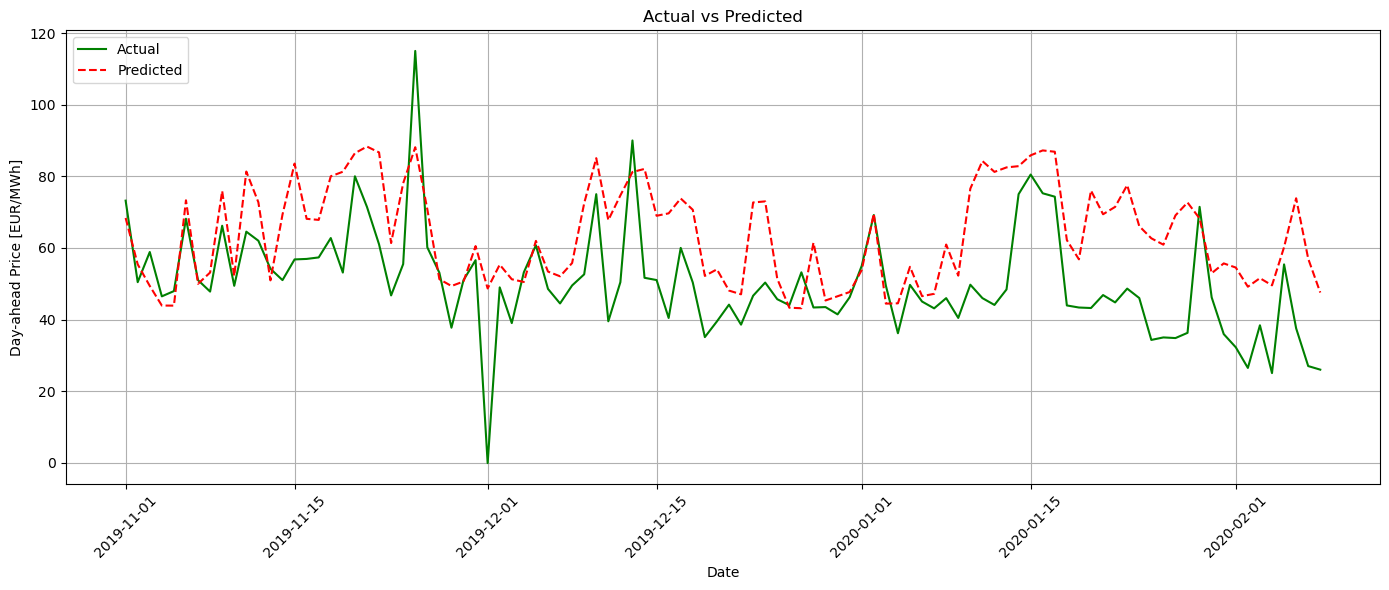

In [4]:
# Plotting the actual vs predicted values
plt.figure(figsize=(14, 6))
plt.plot(test_dates, inv_y, label='Actual', color='Green')
plt.plot(test_dates, inv_yhat, label='Predicted', color='Red', linestyle='dashed')
plt.title('Actual vs Predicted')
plt.ylabel('Day-ahead Price [EUR/MWh]')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.regularizers import L1L2

# Load the dataset
df = pd.read_csv('merged_dataset-2018-2020.csv')

# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
dates = df['Date'].tolist()

# Generate lag features for all the variables except the target
num_lags = 7
for col in df.columns:
    if col != 'Price':
        for lag in range(1, num_lags + 1):
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)

# Drop any columns with datetime data type
df = df.select_dtypes(exclude=['datetime64'])

# Drop NaN rows introduced by the lag features
df.dropna(inplace=True)

# Splitting the dataset
n_train_hours = int(len(df) * 0.8)
train, test = df.iloc[:n_train_hours, :], df.iloc[n_train_hours:, :]

# Extract test dates
test_dates = dates[n_train_hours:n_train_hours + len(test)]

# Separating the target variable
train_X, train_y = train.drop(columns=['Price']), train['Price']
test_X, test_y = test.drop(columns=['Price']), test['Price']

# Scaling the dataset
scaler_X = StandardScaler().fit(train_X)
train_X_scaled = scaler_X.transform(train_X)
test_X_scaled = scaler_X.transform(test_X)

scaler_y = StandardScaler().fit(train_y.values.reshape(-1, 1))
train_y_scaled = scaler_y.transform(train_y.values.reshape(-1, 1))
test_y_scaled = scaler_y.transform(test_y.values.reshape(-1, 1))

# Reshaping for LSTM
train_X_reshaped = train_X_scaled.reshape((train_X_scaled.shape[0], 1, train_X_scaled.shape[1]))
test_X_reshaped = test_X_scaled.reshape((test_X_scaled.shape[0], 1, test_X_scaled.shape[1]))


# LSTM Model Architecture
model = Sequential()

# Input Layer
model.add(LSTM(128, input_shape=(train_X_reshaped.shape[1], train_X_reshaped.shape[2]), return_sequences=True))
model.add(Dropout(0.3))

# Hidden Layers
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(1))

optimizer = Adam(learning_rate=0.01)
model.compile(loss='mae', optimizer=optimizer)

batch_size = 64
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# Training the model
history = model.fit(train_X_reshaped, train_y_scaled, epochs=150, batch_size=batch_size, 
                    validation_data=(test_X_reshaped, test_y_scaled), verbose=2, 
                    shuffle=False, callbacks=[early_stop])





# Prediction
yhat_scaled = model.predict(test_X_reshaped)

# Inverse scaling for forecast
inv_yhat = scaler_y.inverse_transform(yhat_scaled)

# Inverse scaling for actuals
inv_y = scaler_y.inverse_transform(test_y_scaled)

# Extracting the data for the last three months before 2019-11-01
start_date_idx = dates.index(pd.to_datetime('2019-08-01'))
end_date_idx = dates.index(pd.to_datetime('2019-11-01'))

last_three_months_data = df.iloc[start_date_idx:end_date_idx]['Price'].values
last_three_months_dates = dates[start_date_idx:end_date_idx]

# RMSE calculation
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE:', rmse)



Epoch 1/150
7/7 - 5s - loss: 0.7932 - val_loss: 0.8517 - 5s/epoch - 781ms/step
Epoch 2/150
7/7 - 0s - loss: 0.7227 - val_loss: 0.7663 - 53ms/epoch - 8ms/step
Epoch 3/150
7/7 - 0s - loss: 0.7042 - val_loss: 0.6974 - 50ms/epoch - 7ms/step
Epoch 4/150
7/7 - 0s - loss: 0.6783 - val_loss: 0.7454 - 51ms/epoch - 7ms/step
Epoch 5/150
7/7 - 0s - loss: 0.6137 - val_loss: 0.7594 - 50ms/epoch - 7ms/step
Epoch 6/150
7/7 - 0s - loss: 0.6319 - val_loss: 0.6705 - 54ms/epoch - 8ms/step
Epoch 7/150
7/7 - 0s - loss: 0.6191 - val_loss: 0.6229 - 53ms/epoch - 8ms/step
Epoch 8/150
7/7 - 0s - loss: 0.6013 - val_loss: 0.9888 - 51ms/epoch - 7ms/step
Epoch 9/150
7/7 - 0s - loss: 0.5793 - val_loss: 0.7719 - 57ms/epoch - 8ms/step
Epoch 10/150
7/7 - 0s - loss: 0.5595 - val_loss: 0.7476 - 57ms/epoch - 8ms/step
Epoch 11/150
7/7 - 0s - loss: 0.5545 - val_loss: 0.8020 - 49ms/epoch - 7ms/step
Epoch 12/150
7/7 - 0s - loss: 0.5599 - val_loss: 0.7302 - 58ms/epoch - 8ms/step
Epoch 13/150
7/7 - 0s - loss: 0.5500 - val_loss: 

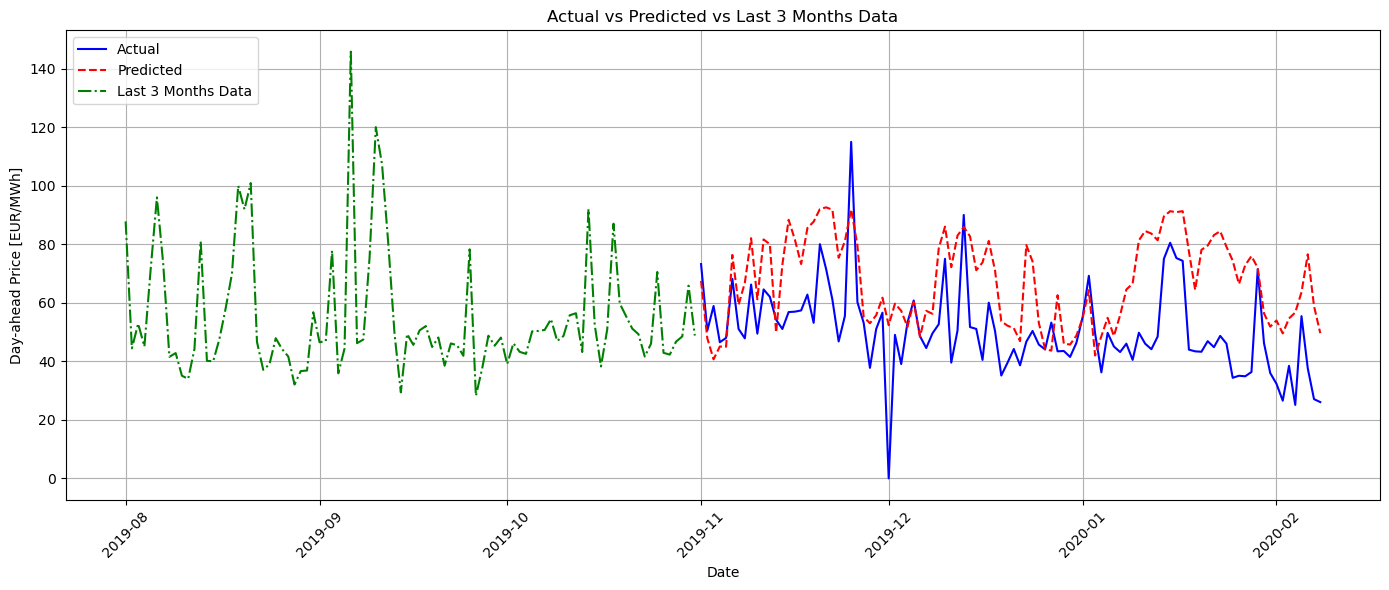

 
Test RMSE: 22.179693243489258


In [9]:
# Plotting the actual vs predicted values along with the data from the last three months
plt.figure(figsize=(14, 6))

# Plotting the Actual values from the test set
plt.plot(test_dates, inv_y, label='Actual', color='Blue')

# Plotting the Predicted values
plt.plot(test_dates, inv_yhat, label='Predicted', color='Red', linestyle='dashed')

# Plotting the Original data from the last three months before 2019-11-01
plt.plot(last_three_months_dates, last_three_months_data, label='Last 3 Months Data', color='Green', linestyle='-.')

# Other plot settings
plt.title('Actual vs Predicted vs Last 3 Months Data')
plt.ylabel('Day-ahead Price [EUR/MWh]')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

print(" ")
# RMSE calculation
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE:', rmse)
